## Setup

In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.metrics import metrics
from darts.models import LightGBMModel
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

d:\AdibFile\AdibProgram\electricity-forecast-experiment\.venv\lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
DATA_PATH = "dataset/appliance_data.csv"

data_raw = pd.read_csv(DATA_PATH)
data_raw["Power (W)"] = data_raw["Voltage (V)"] * data_raw["Ampere (A)"]
data_raw["Datetime"] = pd.to_datetime(data_raw["Timestamp"], format="%Y-%m-%d %H:%M:%S")
data = data_raw.loc[:, ["Datetime", "Power (W)", "Device ID"]]
data.insert(
    loc=1,
    column="Minute of day",
    value=data["Datetime"].apply(lambda x: x.minute + (x.hour * 60)),
)
data


,Datetime,Minute of day,Power (W),Device ID
0,2024-03-01 00:00:00,0,1.620,TV
1,2024-03-01 00:05:00,5,0.225,TV
2,2024-03-01 00:10:00,10,0.225,TV
3,2024-03-01 00:15:00,15,2.205,TV
4,2024-03-01 00:20:00,20,2.115,TV
...,...,...,...,...
10075,2024-03-07 23:35:00,1415,4.550,Refrigerator
10076,2024-03-07 23:40:00,1420,2.850,Refrigerator
10077,2024-03-07 23:45:00,1425,4.250,Refrigerator
10078,2024-03-07 23:50:00,1430,1.850,Refrigerator


In [3]:
def get_data_wo_datetime(data: pd.DataFrame) -> pd.DataFrame:
    data_min_slice = data.columns.difference(["Datetime", "Date"])
    ret = data[data_min_slice]
    assert isinstance(ret, pd.DataFrame)
    return ret

## Minutely Data

In [4]:
pivot_data = []
for dev_id, d in data.groupby("Device ID"):
    assert isinstance(d, pd.DataFrame)
    del d["Device ID"]
    d = d.rename(columns={"Power (W)": f"{dev_id} (W)"})
    pivot_data.append(d)

data_min = pivot_data[0]
for d in pivot_data[1:]:
    data_min = pd.merge(data_min, d)
data_min

,Datetime,Minute of day,AC (W),Lamp (W),PC (W),Refrigerator (W),TV (W)
0,2024-03-01 00:00:00,0,51.48,0.21,23.76,2.65,1.620
1,2024-03-01 00:05:00,5,55.80,0.06,16.32,0.15,0.225
2,2024-03-01 00:10:00,10,23.94,0.18,1.32,3.80,0.225
3,2024-03-01 00:15:00,15,88.56,0.09,7.44,4.95,2.205
4,2024-03-01 00:20:00,20,32.58,0.12,17.40,4.10,2.115
...,...,...,...,...,...,...,...
2011,2024-03-07 23:35:00,1415,64.62,0.03,21.00,4.55,0.630
2012,2024-03-07 23:40:00,1420,19.44,0.15,11.04,2.85,2.205
2013,2024-03-07 23:45:00,1425,35.46,0.09,4.80,4.25,0.270
2014,2024-03-07 23:50:00,1430,45.36,0.21,15.72,1.85,0.810


In [5]:
get_data_wo_datetime(data_min).describe()

,AC (W),Lamp (W),Minute of day,PC (W),Refrigerator (W),TV (W)
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,45.677768,0.153869,717.500000,11.849226,2.517460,1.133772
std,26.387017,0.087185,415.792824,6.906502,1.445094,0.651556
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.040000,0.090000,358.750000,5.760000,1.250000,0.585000
50%,46.080000,0.150000,717.500000,12.120000,2.525000,1.125000
75%,68.760000,0.240000,1076.250000,17.670000,3.800000,1.710000
max,90.000000,0.300000,1435.000000,24.000000,5.000000,2.250000


In [6]:
get_data_wo_datetime(data_min).corr()

,AC (W),Lamp (W),Minute of day,PC (W),Refrigerator (W),TV (W)
AC (W),1.000000,0.019165,0.021820,-0.011646,0.016548,0.032194
Lamp (W),0.019165,1.000000,0.008280,0.038612,-0.008897,0.017624
Minute of day,0.021820,0.008280,1.000000,-0.026074,0.043451,0.008372
PC (W),-0.011646,0.038612,-0.026074,1.000000,0.076567,0.015982
Refrigerator (W),0.016548,-0.008897,0.043451,0.076567,1.000000,0.036290
TV (W),0.032194,0.017624,0.008372,0.015982,0.036290,1.000000


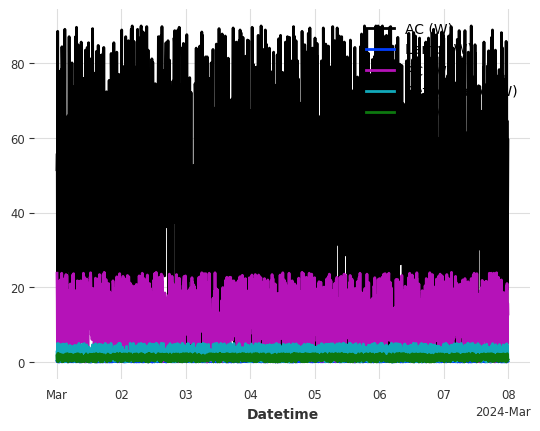

In [7]:
minutely_series = TimeSeries.from_dataframe(
    data_min,
    time_col="Datetime",
    value_cols=[c for c in data_min.columns if c.endswith("(W)")],
)
minutely_series_minute = TimeSeries.from_dataframe(
    data_min, time_col="Datetime", value_cols=["Minute of day"]
)
minutely_series.plot()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_12456\1420396396.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


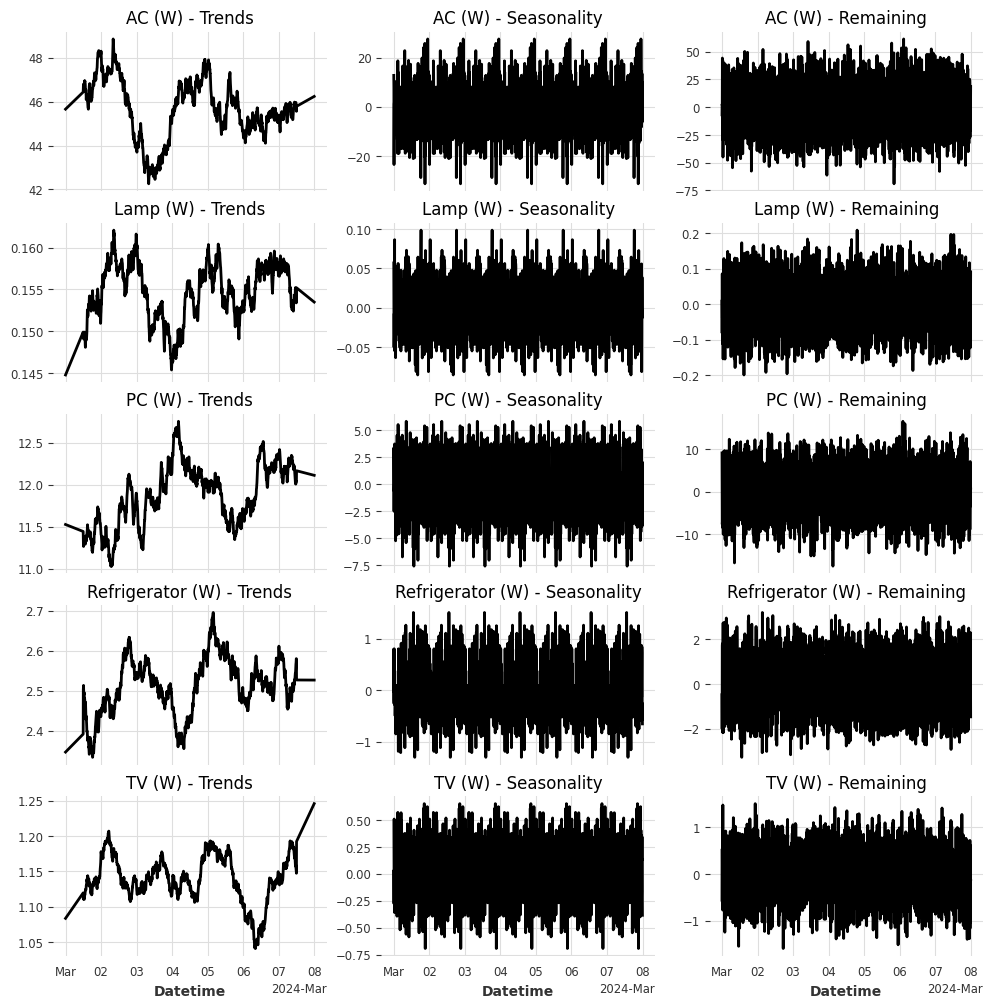

In [8]:
names = minutely_series.components
fig, axs = plt.subplots(len(names), 3, figsize=(12, 12))

for i, c in enumerate(names):
    series = minutely_series.univariate_component(c)
    amp_decomposed = extract_trend_and_seasonality(
        series, freq=int(12 * 24), model=ModelMode.ADDITIVE
    )
    remaining = series - amp_decomposed[0] - amp_decomposed[1]

    amp_decomposed[0].plot(ax=axs[i][0])
    amp_decomposed[1].plot(ax=axs[i][1])
    remaining.plot(ax=axs[i][2])
    axs[i][0].set_title(f"{c} - Trends")
    axs[i][1].set_title(f"{c} - Seasonality")
    axs[i][2].set_title(f"{c} - Remaining")
for i, ax_ in enumerate(axs[::-1]):
    for ax in ax_:
        if i != 0:
            ax.set_xticklabels([])
            ax.set_xlabel("")
        ax.get_legend().remove()
fig.show()

## Daily Data

In [9]:
data_daily = data.copy()
data_daily["Date"] = data_daily["Datetime"].apply(
    lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0)
)
data_daily = data_daily.groupby([data_daily["Date"], "Device ID"]).aggregate(
    {"Power (W)": "sum"}
)
data_daily["Power (W)"] = data_daily["Power (W)"] * 5 / 60 / 1000
data_daily = data_daily.unstack().reset_index()
data_daily.columns = [
    " ".join(col[::-1]).strip().replace("Power (W)", "(kWh)")
    for col in data_daily.columns.values
]
data_daily

,Date,AC (kWh),Lamp (kWh),PC (kWh),Refrigerator (kWh),TV (kWh)
0,2024-03-01,1.120095,0.003588,0.27248,0.060033,0.026692
1,2024-03-02,1.146750,0.003775,0.27799,0.059638,0.027806
2,2024-03-03,1.023000,0.003612,0.28101,0.060500,0.027563
3,2024-03-04,1.124175,0.003728,0.29252,0.058188,0.027139
4,2024-03-05,1.080735,0.003675,0.27841,0.062042,0.027930
5,2024-03-06,1.084860,0.003780,0.29916,0.060808,0.025826
6,2024-03-07,1.094250,0.003693,0.28910,0.061725,0.027517


In [10]:
get_data_wo_datetime(data_daily).describe()

,AC (kWh),Lamp (kWh),PC (kWh),Refrigerator (kWh),TV (kWh)
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1.096266,0.003693,0.284381,0.060419,0.027211
std,0.040080,0.000075,0.009455,0.001306,0.000739
min,1.023000,0.003588,0.272480,0.058188,0.025826
25%,1.082797,0.003644,0.278200,0.059835,0.026916
50%,1.094250,0.003693,0.281010,0.060500,0.027517
75%,1.122135,0.003751,0.290810,0.061267,0.027684
max,1.146750,0.003780,0.299160,0.062042,0.027930


In [11]:
get_data_wo_datetime(data_daily).corr()

,AC (kWh),Lamp (kWh),PC (kWh),Refrigerator (kWh),TV (kWh)
AC (kWh),1.000000,0.433200,-0.095630,-0.474788,-0.034105
Lamp (kWh),0.433200,1.000000,0.631693,-0.175925,-0.183770
PC (kWh),-0.095630,0.631693,1.000000,-0.089377,-0.541581
Refrigerator (kWh),-0.474788,-0.175925,-0.089377,1.000000,0.164348
TV (kWh),-0.034105,-0.183770,-0.541581,0.164348,1.000000


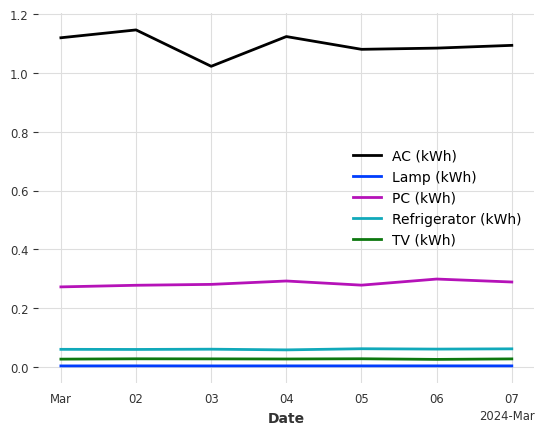

In [12]:
daily_series = TimeSeries.from_dataframe(data_daily, time_col="Date")
daily_series.plot()
plt.show()

## Forecasting

### Data Preparation

In [22]:
VAL_NUM_DAY = 1
val_num = 12 * 24 * VAL_NUM_DAY
train_num = len(minutely_series) - val_num

minutely_series_train_target = minutely_series[:train_num]
minutely_series_train_cov = minutely_series_minute[:train_num]
minutely_series_val_target = minutely_series[train_num:]
minutely_series_val_cov = minutely_series_minute[train_num:]

### Minutely LGBM Forecasting

In [ ]:
MODEL_PATH = "model/lgbm_forecaster.pkl"

#### Train

In [23]:
# 1 hour = 12 data points
model = LightGBMModel(
    lags=12 * 12,
    lags_future_covariates=(12 * 12, 12 * 1),
    output_chunk_length=12 * 1,
)

In [24]:
model.fit(
    series=minutely_series_train_target,
    future_covariates=minutely_series_train_cov,
    val_series=minutely_series_val_target,
    val_future_covariates=minutely_series_val_cov,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124805
[LightGBM] [Info] Number of data points in the train set: 1573, number of used features: 876
[LightGBM] [Info] Start training from score 45.690591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124805
[LightGBM] [Info] Number of data points in the train set: 1573, number of used features: 876
[LightGBM] [Info] Start training from score 0.154520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124805
[LightGBM] [Info] Number of data points in the train set: 1573, number of used features: 876
[LightGBM] [Info] St

LightGBMModel(lags=144, lags_past_covariates=None, lags_future_covariates=(144, 12), output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [25]:
model.save(MODEL_PATH)

#### Test

In [17]:
model: LightGBMModel = LightGBMModel.load(MODEL_PATH) # type: ignore

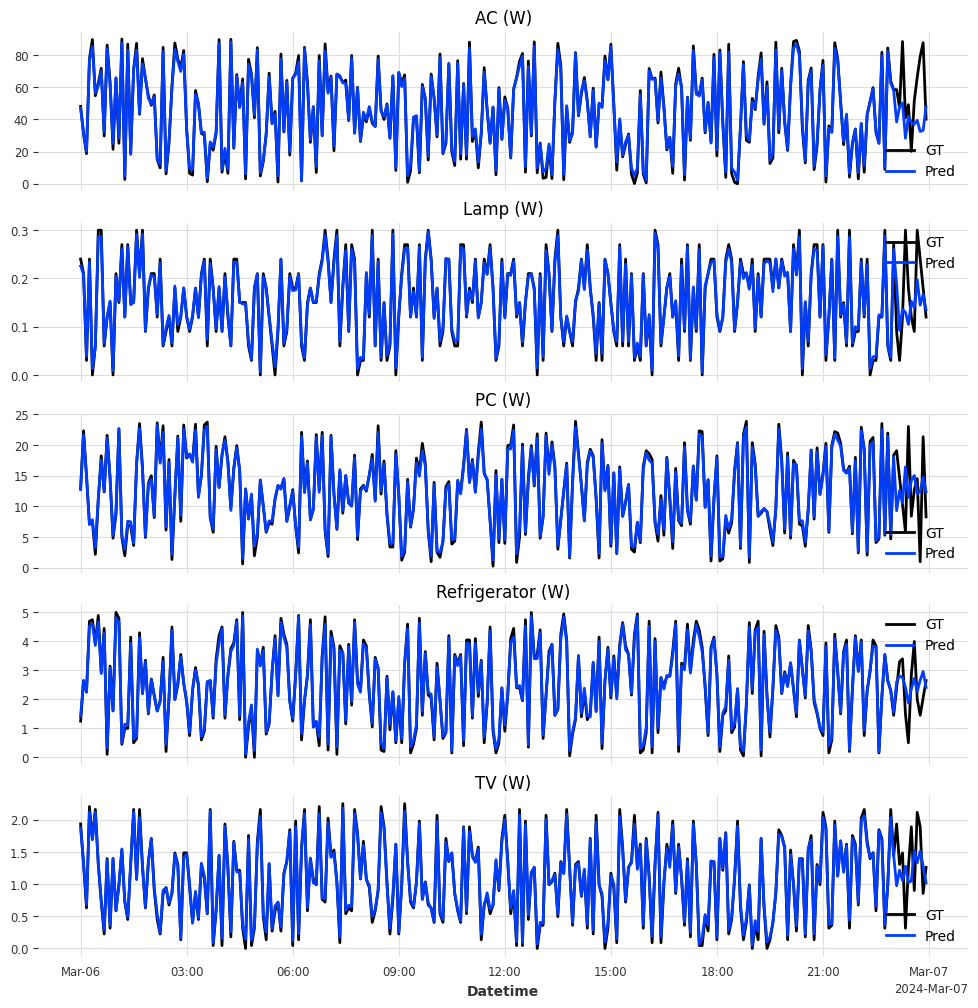

In [16]:
historical_fcast = model.historical_forecasts(
    series=minutely_series_train_target,
    future_covariates=minutely_series_minute,
    retrain=False,
)
assert isinstance(historical_fcast, TimeSeries)

start_show = 12 * 24 * 1
names = minutely_series_train_target.components
fig, axs = plt.subplots(len(names), 1, figsize=(12, 12))
for i, c in enumerate(names):
    minutely_series_train_target[-start_show:].univariate_component(c).plot(
        ax=axs[i], label="GT"
    )
    historical_fcast[-start_show:].univariate_component(c).plot(ax=axs[i], label="Pred")
    axs[i].set_title(c)
for i, ax_ in enumerate(axs[::-1]):
    if i != 0:
        ax_.set_xticklabels([])
        ax_.set_xlabel("")

C:\Users\user\AppData\Local\Temp\ipykernel_12456\4167092138.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


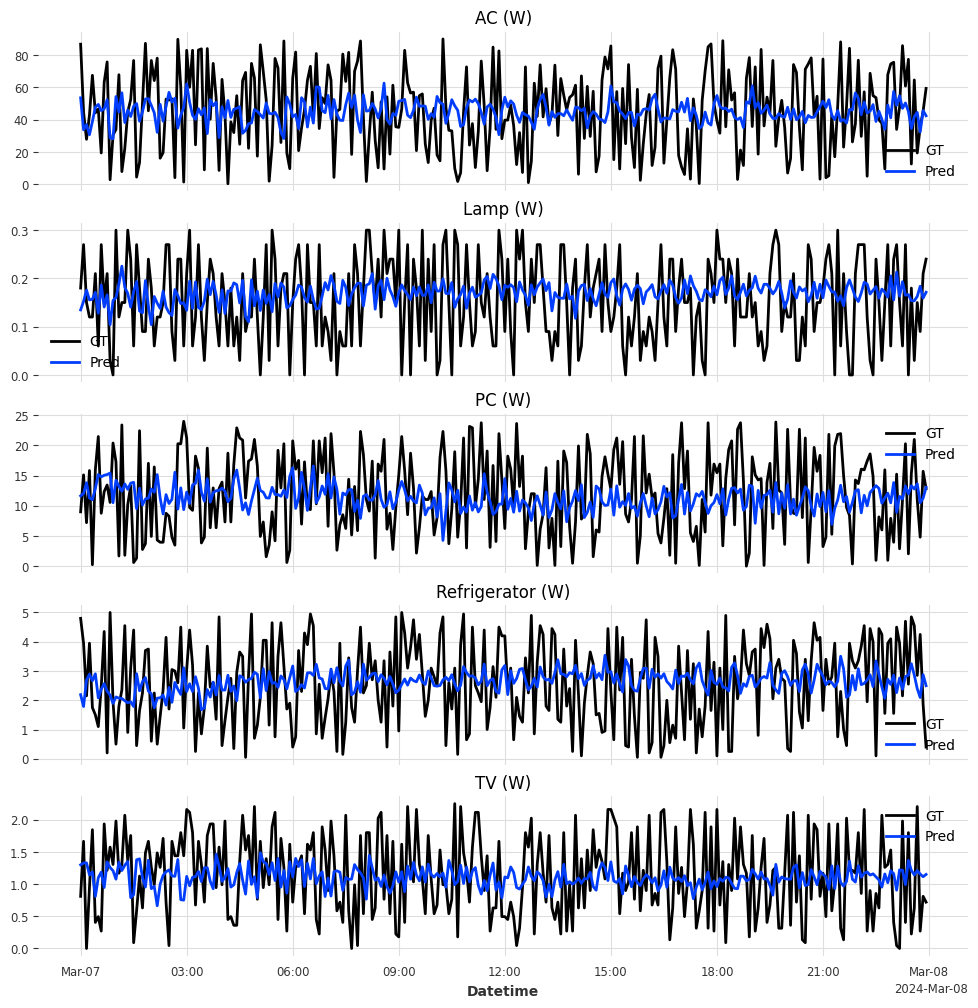

In [18]:
predicted = model.predict(
    len(minutely_series_val_target),
    series=minutely_series_train_target,
    future_covariates=minutely_series_minute,
)
assert isinstance(predicted, TimeSeries)

names = minutely_series_val_target.components
fig, axs = plt.subplots(len(names), 1, figsize=(12, 12))
for i, c in enumerate(names):
    minutely_series_val_target.univariate_component(c).plot(ax=axs[i], label="GT")
    predicted.univariate_component(c).plot(ax=axs[i], label="Pred")
    axs[i].set_title(c)
for i, ax_ in enumerate(axs[::-1]):
    if i != 0:
        ax_.set_xticklabels([])
        ax_.set_xlabel("")
fig.show()

In [19]:
assert isinstance(predicted, TimeSeries)

def calculate_kwh(series: TimeSeries) -> float:
    wm = (series * 5).sum(axis=1).sum(axis=0).values()[0, 0]
    return wm / 1000 / 60


def calculate_kwh_err(
    gt_series: TimeSeries, pred_Series: TimeSeries
) -> Tuple[float, float]:
    gt_kwh = calculate_kwh(gt_series)
    pred_kwh = calculate_kwh(pred_Series)
    err = abs(pred_kwh - gt_kwh)
    err_percentage = err / gt_kwh
    return err, err_percentage


names = minutely_series_val_target.components
eval_data = []
for c in names:
    gt = minutely_series_val_target.univariate_component(c)
    pred = predicted.univariate_component(c)
    mae = metrics.mae(
        gt,
        pred,
        intersect=True,
    )
    mase = metrics.mase(
        gt,
        pred,
        insample=minutely_series_train_target.univariate_component(c),
        m=1,
        intersect=True,
    )
    kwh_err, kwh_err_perc = calculate_kwh_err(gt, pred)
    eval_data.append([c, mae, mase, kwh_err, kwh_err_perc])

mae = metrics.mae(minutely_series_val_target, predicted, True)
mase = metrics.mase(
    minutely_series_val_target,
    predicted,
    insample=minutely_series_train_target,
    m=1,
    intersect=True,
)
kwh_err, kwh_err_perc = calculate_kwh_err(minutely_series_val_target, predicted)
eval_data.append(["Overall", mae, mase, kwh_err, kwh_err_perc])

eval = pd.DataFrame(
    eval_data, columns=["Category", "Watt MAE", "Watt MASE", "kWh Err", "kWh Err (%)"]
)
eval

,Category,Watt MAE,Watt MASE,kWh Err,kWh Err (%)
0,AC (W),22.299667,0.721500,0.013951,0.012750
1,Lamp (W),0.081023,0.814424,0.000377,0.101977
2,PC (W),6.050118,0.763642,0.016670,0.057660
3,Refrigerator (W),1.266344,0.760397,0.001737,0.028144
4,TV (W),0.559238,0.734156,0.001000,0.036349
5,Overall,6.051278,0.758824,0.029507,0.019988


### Simple Daily kWh Average Forecasting

In [20]:
daily_train_num = len(data_daily) - VAL_NUM_DAY
data_daily_train = data_daily[:daily_train_num]
data_daily_val = data_daily[daily_train_num:]
mean_kwh = data_daily_train.mean()
mean_kwh

Date                  2024-03-03 12:00:00
AC (kWh)                         1.096602
Lamp (kWh)                       0.003693
PC (kWh)                         0.283595
Refrigerator (kWh)               0.060201
TV (kWh)                         0.027159
dtype: object

In [21]:
mean_kwh_val = data_daily_val.mean()
eval_data = []
for c in data_daily_val.columns:
    if c == "Date":
        continue
    pred_kwh = mean_kwh[c] * VAL_NUM_DAY
    gt_kwh = mean_kwh_val[c]
    err = abs(pred_kwh - gt_kwh)
    err_perc = err / gt_kwh
    eval_data.append([c, gt_kwh, pred_kwh, err, err_perc])

gt_kwh = np.sum([d[1] for d in eval_data])
pred_kwh = np.sum([d[2] for d in eval_data])
err = abs(pred_kwh - gt_kwh)
err_perc = err / gt_kwh
eval_data.append(["Overall", gt_kwh, pred_kwh, err, err_perc])

eval = pd.DataFrame(
    eval_data, columns=["Category", "GT kWh", "Pred kWh", "kWh Err", "kWh Err (%)"]
)
eval

,Category,GT kWh,Pred kWh,kWh Err,kWh Err (%)
0,AC (kWh),1.094250,1.096602,2.352500e-03,0.002150
1,Lamp (kWh),0.003693,0.003693,4.166667e-07,0.000113
2,PC (kWh),0.289100,0.283595,5.505000e-03,0.019042
3,Refrigerator (kWh),0.061725,0.060201,1.523611e-03,0.024684
4,TV (kWh),0.027517,0.027159,3.581250e-04,0.013014
5,Overall,1.476285,1.471251,5.033819e-03,0.003410
